In [89]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import mpl_toolkits.mplot3d.art3d as art3d
import py_gauge_mc

from tqdm.notebook import tqdm

In [44]:
def p_to_dim_dim(p):
    if p == 3:
        return 1,2,3
    if p == 4:
        return 1,3,2
    if p == 5:
        return 2,3,1
    return None


def plot_state(state):
    T = np.arange(state.shape[0])
    X = np.arange(state.shape[1])
    Y = np.arange(state.shape[2])
    Z = np.arange(state.shape[3])
    P = np.arange(state.shape[4])
    TT, XX, YY, ZZ, PP = np.meshgrid(T,X,Y,Z,P)
    indices = np.stack([TT,XX,YY,ZZ,PP], axis=-1)
    nonzero_indices = indices[state!=0,:]
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim((0,state.shape[1]))
    ax.set_ylim((0,state.shape[2]))
    ax.set_zlim((0,state.shape[3]))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    dims = ['x', 'y', 'z']
    for (t,x,y,z,p) in indices.reshape(-1,5):
        if t != 0:
            continue
        
        pdims = p_to_dim_dim(p)
        
        if pdims is not None:
            first,second,normal = pdims
            
            zdir = dims[normal - 1]
            if zdir == "y":
                xy1, z1 = (x, z), y
            elif zdir == "x":
                xy1, z1 = (y, z), x
            else:
                xy1, z1 = (x, y), z
            
            p = Rectangle(xy1, 1, 1, color='blue', alpha=0.1 * abs(state[t,x,y,z,p]))
            ax.add_patch(p)
            art3d.pathpatch_2d_to_3d(p, z=z1, zdir=zdir)

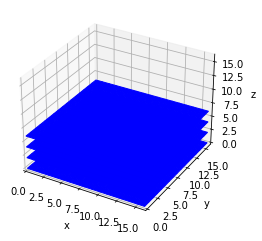

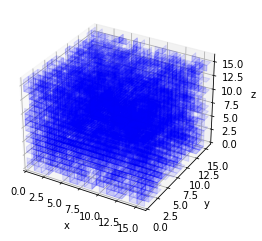

[ 0  0  0 40  0  0]


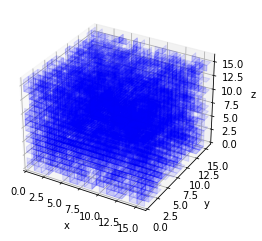

[ 0  0  0 40  0  0]


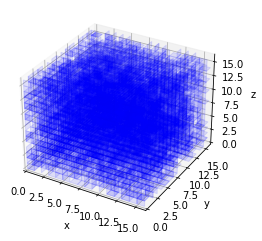

[ 0  0 -1 40  0  0]


In [72]:
L = 16
state = np.zeros((L,L,L,L,6), dtype=np.int32)

state[0,:,:,0,3] = 10
state[0,:,:,2,3] = 10
state[0,:,:,4,3] = 10
state[0,:,:,6,3] = 10
vns = [(n**2)/2.0 for n in range(30)]
graph = py_gauge_mc.GPUGaugeTheory(L,L,L,L,vns, initial_state=state)

plot_state(graph.get_graph_state())
plt.show()

graph.run_local_update(10000)

plot_state(graph.get_graph_state())
plt.show()

print(graph.get_winding_nums())

graph.run_global_update()

plot_state(graph.get_graph_state())
plt.show()

print(graph.get_winding_nums())

winding_nums = graph.simulate_and_get_winding_nums(10000)

plot_state(graph.get_graph_state())
plt.show()

print(graph.get_winding_nums())

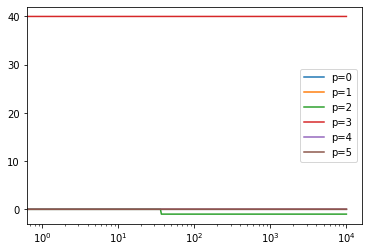

In [83]:
for i in range(winding_nums.shape[1]):
    plt.plot(winding_nums[:,i], label=f'p={i}')
plt.xscale('log')
plt.legend()
plt.show()

## Check plane costs

In [95]:
def get_average_plane_costs(state, vns):
    plus_delta_e = numpy_vns[abs(state)] - numpy_vns[abs(state + 1)]
    minus_delta_e = numpy_vns[abs(state)] - numpy_vns[abs(state - 1)]
    positives = []
    negatives = []
    for p in range(state.shape[-1]):
        p_mean = plus_delta_e[:,:,:,:,p].mean()
        p_var = plus_delta_e[:,:,:,:,p].var()
        m_mean = minus_delta_e[:,:,:,:,p].mean()
        m_var = minus_delta_e[:,:,:,:,p].var()
        positives.append((p_mean, p_var))
        negatives.append((m_mean, m_var))
    return positives, negatives

In [113]:
data = []

ls = [4,8,12,16]
ks = np.linspace(0.1,1.0,20)

for L in tqdm(ls, desc="L"):
    subdata = []
    for k in tqdm(ks, desc="K", leave=False):
        vns = [(n**2)*k for n in range(100)]
        numpy_vns = np.array(vns)
        graph = py_gauge_mc.GPUGaugeTheory(L,L,L,L,vns)
        before = get_average_plane_costs(graph.get_graph_state(), numpy_vns)
        graph.run_local_update(10000)
        after = get_average_plane_costs(graph.get_graph_state(), numpy_vns)
        subdata.append([before, after])
    
    data.append(subdata)

L:   0%|          | 0/4 [00:00<?, ?it/s]

K:   0%|          | 0/20 [00:00<?, ?it/s]

K:   0%|          | 0/20 [00:00<?, ?it/s]

K:   0%|          | 0/20 [00:00<?, ?it/s]

K:   0%|          | 0/20 [00:00<?, ?it/s]

In [114]:
data_np = np.array(data)
data_np.shape

(4, 20, 2, 2, 6, 2)

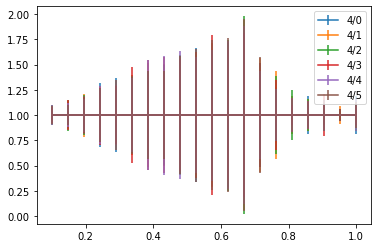

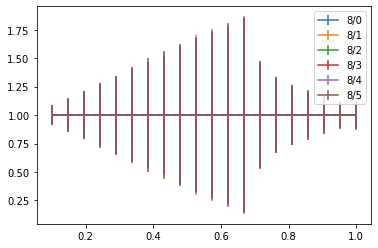

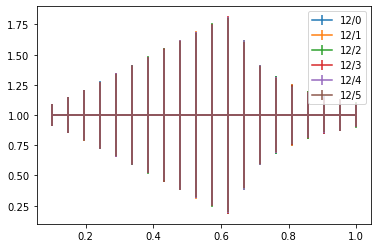

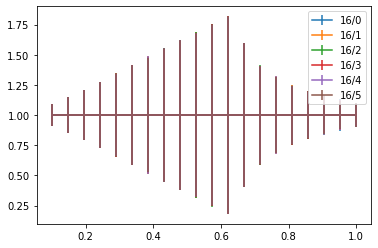

In [115]:
for L, L_data in zip(ls, data_np):
    for p in range(L_data.shape[-2]):
        plt.errorbar(ks, L_data[:,1,0,p,0]/L_data[:,0,0,p,0], yerr=L_data[:,1,0,p,1], label="{}/{}".format(L,p))
    plt.legend()
    plt.show()